# Crop and Weed detection Dataset

## Data Loading

### Data Description
We have one folder with 512 * 512 rgb images and text file 

Text file named same as image file name contains label (0 : crop , 1 : weed) along with bounding boxes coordinates so iam gonna extract labels and append crop and weed images into separate lists

In [3]:
import os 
from PIL import Image
path = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/"

crops = []  # label 0
weeds = []  # label 1

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        image_path = os.path.join(path,filename.replace(".txt",".jpeg"))
        if not os.path.exists(image_path):
            print(f"Image does not exits")
        else:
            image = Image.open(image_path)

        text_path = os.path.join(path,filename)
        with open(text_path,"r") as f:
            for line in f:
                label = int(line.split()[0])
                if label == 0:
                    crops.append(image)
                elif label == 1:
                    weeds.append(image)
                    

In [4]:
print(f"Number of crops examples : ",len(crops))
print(f"Number of weeds examples : ",len(weeds))

Number of crops examples :  1212
Number of weeds examples :  860


There is a class imbalance , iam not gonna augmment data with new examples becuase the dataset auther have already do that to a large extent 

So I will simply gonna train model with class imbalance and if I didnt get better accuracy I will think about add more examples

## Nerual Network Architecture

### Assumptions 
Assignmet says neural network based detection so Iam assuming we only have to use plain neural network without convolution

In [5]:
bits = 512 * 512 *3* 4096 * 32   # image size = 512 * 512
print(bits)
GBs = (((bits/8)/1000)/1000)/1000
print(f"Memory Required for only input layer tensors = {GBs} gb")

103079215104
Memory Required for only input layer tensors = 12.884901888 gb


In [6]:
bits = 256 * 256 *3* 4096 * 32  # image size = 256 * 256
print(bits)
GBs = (((bits/8)/1000)/1000)/1000
print(f"Memory Required for only input layer tensors = {GBs} gb")

25769803776
Memory Required for only input layer tensors = 3.221225472 gb


In [7]:
# Image size is 512 * 512 and it is a rgb image so neural network input size will be 
# 512 * 512 * 3 = 786,432 if I set hidden layer neurons equal to 4096 atleast the amount
# of memory it will be needed is 786,432 * 4096 * 32 = 103079215104 bits (12.88 GB) and this
# large matrix multiplication will take eons to runs on a cpu even small number of epochs
# we need to resize image to a value in which we dont loose much information.
# I will use pytorch for defining neural network because training is faster in pytorch
# So iam gonna  resize images using pytorch transform method to resize and 
# convert images to pytorch tensors


In [8]:
# Image Resize and convert to pytorch tensors
import torch
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256 * 256
    transforms.ToTensor(),          # Convert to tensor
])

# Create a datasetlist containing image and label 
X = []
Y = []
for image in crops:
    resized_image = transform(image)
    X.append(resized_image)
    Y.append(torch.tensor(0,dtype=torch.long))

for image in weeds:
    resized_image = transform(image)
    X.append(resized_image)
    Y.append(torch.tensor(1,dtype=torch.long))

del crops
del weeds
X = torch.stack(X)
Y = torch.stack(Y)

In [9]:
train_ratio = 0.7
val_ratio = train_ratio + 0.1

total_examples = len(X)

# Training Data
X_train = X[:int(total_examples*train_ratio)]
Y_train = Y[:int(total_examples*train_ratio)]

# Validation Data
X_val = X[int(total_examples*train_ratio):int(total_examples*val_ratio)]
Y_val = Y[int(total_examples*train_ratio):int(total_examples*val_ratio)]

# Test Data
X_test = X[int(total_examples*val_ratio):]
Y_test = X[int(total_examples*val_ratio):]



In [10]:
total_examples

2072

In [11]:
# Neural architecture
import torch.nn as nn
class simpleNeuralNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super(simpleNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 4096) 
        self.fc2 = nn.Linear(4096,2048)
        self.fc3 = nn.Linear(2048,1024)
        self.fc4 = nn.Linear(1024,output_size)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


## Memory Calculation

In [13]:
# 1 tensor takes 32 bits or 4bytes
# Model Weights and Baises Memory

fc1_param = 256*256*3*4096 + 4096
fc2_param = 4096 * 2048  + 2048
fc3_param = 2048 * 1024 + 1024
fc4_param = 1024 * 2 + 2

total_param = fc1_param + fc2_param + fc3_param + fc4_param

parameters_memory = (total_param*4)/10**9
print(f"Model Parameters Memory : {parameters_memory} gb")

Model Parameters Memory : 3.263205384 gb


In [14]:
# Forward Pass Memory (memory required for saving matrix multiplications results tensors or you can
# say to save each layer output tensors)

input_batch_size = total_examples
input_mem = (input_batch_size * 256*256*3) * 4
fc1_mem =   (input_batch_size * 4096) * 4
fc2_mem =   (input_batch_size * 2048) * 4
fc3_mem =   (input_batch_size * 1024) * 4
fc4_mem =  (input_batch_size * 2) * 4

forward_pass_mem = (input_mem+fc1_mem+fc2_mem+fc3_mem+fc4_mem)/10**9
print(f"Total Foward Pass Memory = {forward_pass_mem} gb")

Total Foward Pass Memory = 1.688912064 gb


In [15]:
# Backward Pass or gradient memory
# In backward pass gradient of each weight and bias and also gradient of output of each layer is calculated
# 
gradient_memory = parameters_memory +  forward_pass_mem
print(f"Memory Required for save gradient tensors = {gradient_memory} gb")

Memory Required for save gradient tensors = 4.952117448 gb


In [16]:
# Optimizer
# So Have you ever seen a beta parameter in Adam optimizer fucntion its default value is (0.9 , 0.99)

# So for each weight and bias in the model optimizers in pytorch itsave extra info 
# Like in Adam for each weight and bias it stores First moment Estimate (Mt) and Second moment
# Estimate (Vt) values so memory taken by Adam is equal to 2 * model parameters memory

# What is Mt and Vt here?
# For each weight and bias we calculate gradient during backward pass so what optimizer like
# Adam does it store gradient's exponentially moving average (EMA) or Estimated Mean for all previous 
# previous step gradient
# and it also stores EMA of square of gradient value or Estimated Variance for all previous step g
# gradients

# So when optimizer update weights i.e add gradients to weights it does not add gradient calculated in 
# this step but it add mean of past and current gradient to the weights and they named this
# thing as momentum and created all the theory around it.

# Role of Betas in calculation Estimated Mean of Gradient
# Estimated Mean Gradient  = beta1 * Previous Estimated Mean Gradient + (1-beta1) * current step gradient
# Estimated Variance of Gradient = beta2 * Previous Estimated Variance + (1-beta2) * current step gradient

# Weight Update Equation
# Weight = Weight - Learning_Rate * (Mean Gradient/sqrt(Variance))

# so intead of using current step gradient for weight update we divide mean of gradient with 
# standard deviation of gradients and use that for updating weights

In [17]:
# Optimizer Memory 
optimizer_memory = 2 * parameters_memory
print(f"Optimizer Memory = {optimizer_memory} gb")

Optimizer Memory = 6.526410768 gb


In [20]:
Total_memory = parameters_memory + forward_pass_mem + gradient_memory + optimizer_memory
print(f"Total Memory Required = {Total_memory} gb")

Total Memory Required = 16.430645664 gb


In [23]:
# Training
import torch.optim as optim
torch.manual_seed(5416)  # For reproducibility
model = simpleNeuralNetwork(256*256*3,2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(20):
    model.train()
    # Forward pass
    outputs = model(X_train)
    loss = loss_func(outputs, Y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    eval_outputs = model(X_val)
    eval_loss = loss_func(eval_outputs,Y_val)
    
    print(f"Train Loss = {loss.item()} , Validation Loss = {eval_loss.item()}")

Train Loss = 0.68284672498703 , Validation Loss = 21.513734817504883
Train Loss = 3.465132236480713 , Validation Loss = 5.879743576049805
Train Loss = 0.9488368630409241 , Validation Loss = 0.0008418560610152781
Train Loss = 6.3084211349487305 , Validation Loss = 2.175903797149658
Train Loss = 0.4490954577922821 , Validation Loss = 7.217347621917725
Train Loss = 1.162204623222351 , Validation Loss = 8.029694557189941
Train Loss = 1.2924150228500366 , Validation Loss = 6.148950576782227
Train Loss = 0.9909631609916687 , Validation Loss = 2.6174416542053223
Train Loss = 0.4822602868080139 , Validation Loss = 0.15099036693572998
Train Loss = 1.6932555437088013 , Validation Loss = 2.0571093559265137
Train Loss = 0.4417138695716858 , Validation Loss = 4.74048376083374
Train Loss = 0.769102156162262 , Validation Loss = 5.862395286560059
Train Loss = 0.9447103142738342 , Validation Loss = 5.490005016326904
Train Loss = 0.8856042623519897 , Validation Loss = 3.8953733444213867
Train Loss = 0.6

* **Training is taking too long on cpu I cant wait so iam gonna use mini batch that can fit exactly into 16 gb vram memory of gpu and run model on gpu**
  
* **As you can see the loss is not consistent and there is much difference between train and  validation loss beacuse validation examples are very less**
  
* 
**Iam gonna add dropout so model does not overfit and also add batch normalization so that I can get a nice linearly decreasing loss**


* **I have very less data so iam only spliting it into training and test above and also here iam gonna split data randomly**


* **Architecture is same as above**

#### Below is the complete code 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

torch.manual_seed(5416)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_path = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/"

class CropsWeedsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for filename in os.listdir(root_dir):
            if filename.endswith(".txt"):
                image_path = os.path.join(root_dir, filename.replace(".txt", ".jpeg"))

                if not os.path.exists(image_path):
                    print("Image not found")
                    continue  # Skip if missing image

                with open(os.path.join(root_dir, filename), "r") as f:
                    for line in f:
                        label = int(line.split()[0])  # Extract label
                        self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert to tensor
])

# Load dataset
dataset = CropsWeedsDataset(dataset_path, transform=transform)

# Split into 80% training & 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using device: cuda


In [6]:


class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=256*256*3, num_classes=2):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 4096)  
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)  # Flatten image
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  
        return x

# Initialize model
model = FullyConnectedNN().to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs =20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training Complete!")


Epoch [1/20], Loss: 0.3056
Epoch [2/20], Loss: 0.1125
Epoch [3/20], Loss: 0.0726
Epoch [4/20], Loss: 0.0584
Epoch [5/20], Loss: 0.0470
Epoch [6/20], Loss: 0.0363
Epoch [7/20], Loss: 0.0452
Epoch [8/20], Loss: 0.0360
Epoch [9/20], Loss: 0.0260
Epoch [10/20], Loss: 0.0263
Epoch [11/20], Loss: 0.0276
Epoch [12/20], Loss: 0.0273
Epoch [13/20], Loss: 0.0215
Epoch [14/20], Loss: 0.0227
Epoch [15/20], Loss: 0.0162
Epoch [16/20], Loss: 0.0238
Epoch [17/20], Loss: 0.0159
Epoch [18/20], Loss: 0.0147
Epoch [19/20], Loss: 0.0264
Epoch [20/20], Loss: 0.0222
Training Complete!


In [7]:
# Neural Architecture
# Evaluate on test set
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 94.70%


### **Note** 
#### Above Code was written before the update of requirements and details about Question 3 in the manual so it does not include 3 classes and evalution metrics. Do not deduct marks for that becuase I have added these things here. 

#### Consider this as start of question 3 I didnt remove the above part so I dont have to explain how I wrote the code again. Code and architecture is almost same but here I have used different dataset with 9 classes

# Deep Weeds Dataset

In [1]:
import os
import pandas as pd
from glob import glob

# Path to label folder
label_folder = "/kaggle/input/deepweeds/labels"

# Read all CSV files
train_csvs = glob(os.path.join(label_folder, "train_*.csv"))
val_csvs = glob(os.path.join(label_folder, "val_*.csv"))
test_csvs = glob(os.path.join(label_folder, "test_*.csv"))

# Merge all CSVs into one dataset each
def merge_csvs(csv_files):
    dfs = [pd.read_csv(f, names=["image", "label"]) for f in csv_files]
    return pd.concat(dfs, ignore_index=True)

train_df = merge_csvs(train_csvs)
val_df = merge_csvs(val_csvs)
test_df = merge_csvs(test_csvs)

print(train_df.head())  


                   image  label
0               Filename  Label
1  20171219-114402-3.jpg      8
2  20180119-110612-1.jpg      8
3  20170129-102930-0.jpg      8
4  20171203-172701-3.jpg      8


In [2]:
print(f"Training Examples : {len(train_df)}")
print(f"Validation Examples : {len(val_df)}")
print(f"Test Examples : {len(test_df)} ")

Training Examples : 52530
Validation Examples : 17516
Test Examples : 17514 


In [3]:
class_names = {
    0: "Chinee Apple",
    1: "Lantana",
    2: "Parkinsonia",
    3: "Parthenium",
    4: "Prickly Acacia",
    5: "Rubber Vine",
    6: "Siam Weed",
    7: "Snake Weed",
    8: "Other"
}


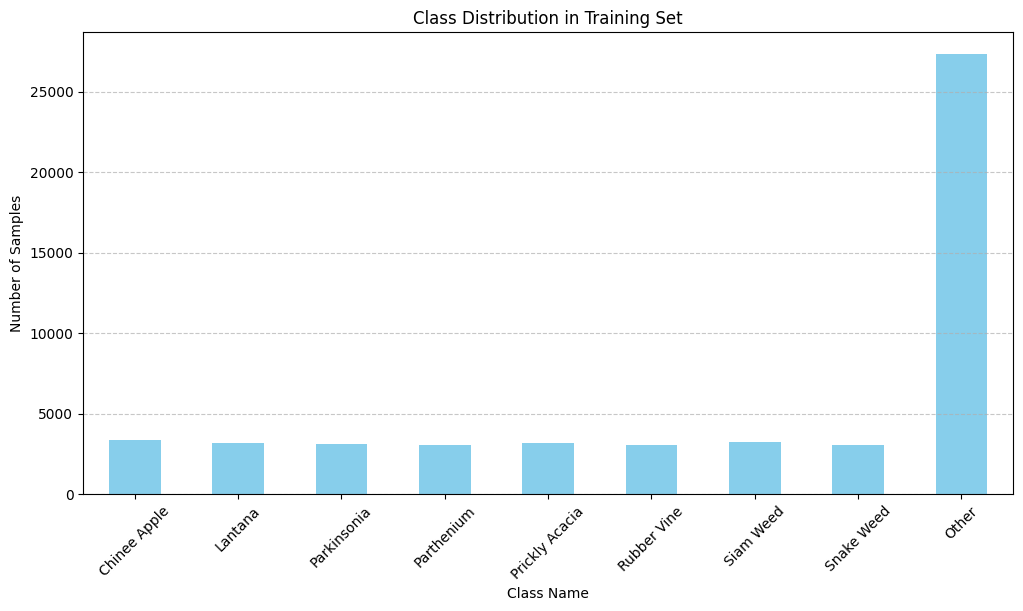

In [4]:
import matplotlib.pyplot as plt
# Convert labels to integers
train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
train_df = train_df.dropna().astype({'label': 'int'})  # Drop NaN and ensure int labels

# Count class distribution
class_counts = train_df['label'].value_counts().sort_index()

# Map numeric labels to class names
class_counts.index = [class_names[idx] for idx in class_counts.index]

# Plot class distribution
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### There is no description for other class label on kaggle dataset so iam simply dropping it becuase it is causing huge class imbalance

In [5]:
# Convert labels to integers and remove "Other" class (label 8)
train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
train_df = train_df.dropna().astype({'label': 'int'})  # Drop NaN and convert to int
train_df = train_df[train_df['label'] != 8]  # Remove "Other" class

val_df['label'] = pd.to_numeric(val_df['label'], errors='coerce')
val_df = val_df.dropna().astype({'label': 'int'})
val_df = val_df[val_df['label'] != 8]  # Remove "Other" class

test_df['label'] = pd.to_numeric(test_df['label'], errors='coerce')
test_df = test_df.dropna().astype({'label': 'int'})
test_df = test_df[test_df['label'] != 8]  # Remove "Other" class

In [6]:
len(train_df)  , len(val_df)

(25208, 8404)

#### Validation set contains 8404 examples iam only keeping 1000 in val set and adding the remaining to train set

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
torch.manual_seed(5416)

# Define Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name, label = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, img_name)
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalize so that all there dimension  R, G , B values have mean and std equal to 0.5
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Paths
image_folder = "/kaggle/input/deepweeds/images"

# Create Datasets
train_df = pd.concat([train_df, val_df.iloc[1000:]], ignore_index=True)
val_df = val_df.iloc[:1000]  # Keep first 1000 samples for validation
train_dataset = ImageDataset(train_df, image_folder, transform=transform)
val_dataset = ImageDataset(val_df, image_folder, transform=transform)
test_dataset = ImageDataset(test_df, image_folder, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
len(train_loader) * 32  # Total Training Examples

32640

In [9]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size=256*256*3, num_classes=8):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 4096)  
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512,num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)  # Flatten image
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)  
        return x

# Model parameters
input_size = 256 * 256 * 3  
output_size = 8  # 8 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

num_epochs = 5  

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total_samples * 100)
    train_f1_scores.append(f1_score(all_labels, all_preds, average='weighted'))
    train_precisions.append(precision_score(all_labels, all_preds, average='weighted'))
    train_recalls.append(recall_score(all_labels, all_preds, average='weighted'))

    # Validation
    model.eval()
    val_loss, correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total_samples * 100)
    val_f1_scores.append(f1_score(all_labels, all_preds, average='weighted'))
    val_precisions.append(precision_score(all_labels, all_preds, average='weighted'))
    val_recalls.append(recall_score(all_labels, all_preds, average='weighted'))

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_losses[-1]}, Train Acc={train_accuracies[-1]}%, "
          f"Val Loss={val_losses[-1]}, Val Acc={val_accuracies[-1]}%")

    print("\n")

    print(f"Train F1: {train_f1_scores[-1]}, Val F1: {val_f1_scores[-1]}, "
          f"Train Precision: {train_precisions[-1]}, Val Precision: {val_precisions[-1]}, "
          f"Train Recall: {train_recalls[-1]}, Val Recall: {val_recalls[-1]}")

    print(90*"-")
    print("\n")



Epoch 1: Train Loss=1.3752699323436792, Train Acc=49.84054949098491%, Val Loss=0.603168573230505, Val Acc=80.30000000000001%


Train F1: 0.49505006168345334, Val F1: 0.8034279087624693, Train Precision: 0.4960103617336641, Val Precision: 0.8155666829480371, Train Recall: 0.49840549490984914, Val Recall: 0.803
------------------------------------------------------------------------------------------


Epoch 2: Train Loss=0.46587279730421655, Train Acc=84.50876977799582%, Val Loss=0.14629139500902966, Val Acc=95.39999999999999%


Train F1: 0.8449728909255596, Val F1: 0.9541205892736759, Train Precision: 0.8451061234029836, Val Precision: 0.956009095214892, Train Recall: 0.8450876977799583, Val Recall: 0.954
------------------------------------------------------------------------------------------


Epoch 3: Train Loss=0.240485341089102, Train Acc=91.97228014227892%, Val Loss=0.06573161849519238, Val Acc=97.89999999999999%


Train F1: 0.9197143471627865, Val F1: 0.9790930694186195, Train 

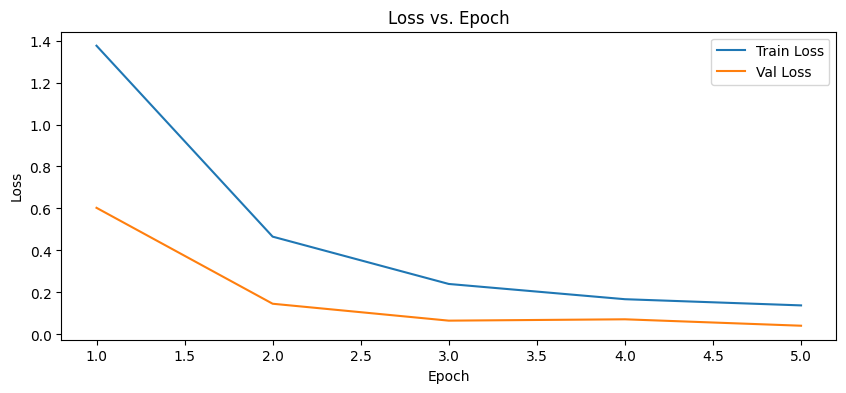

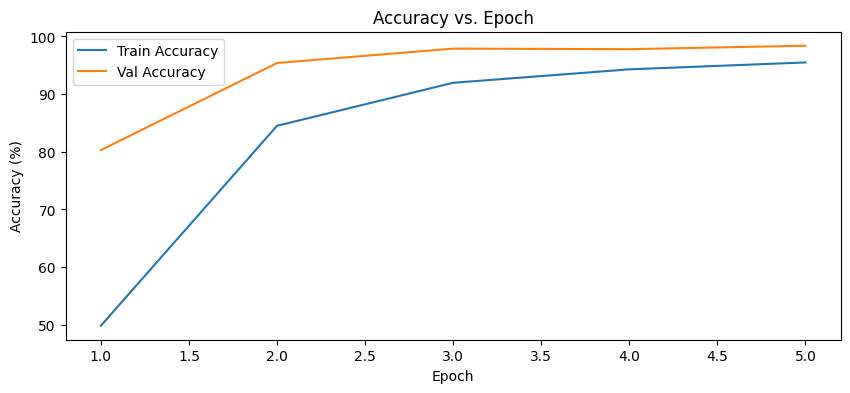

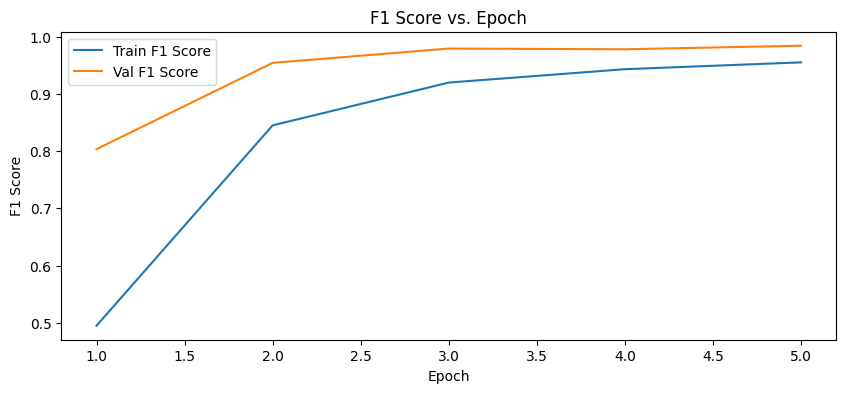

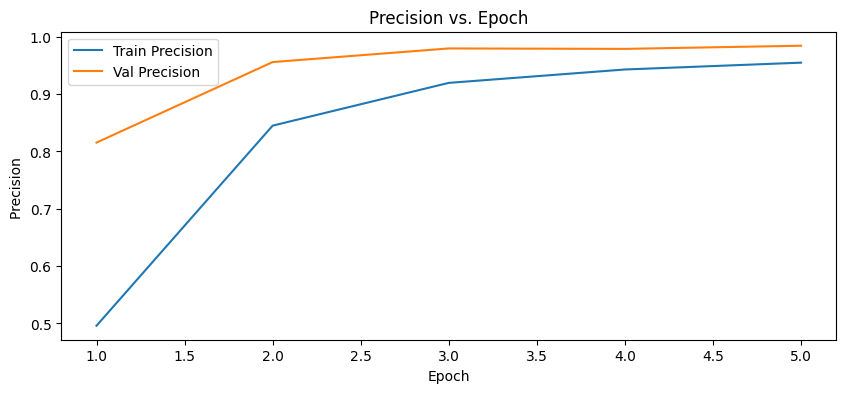

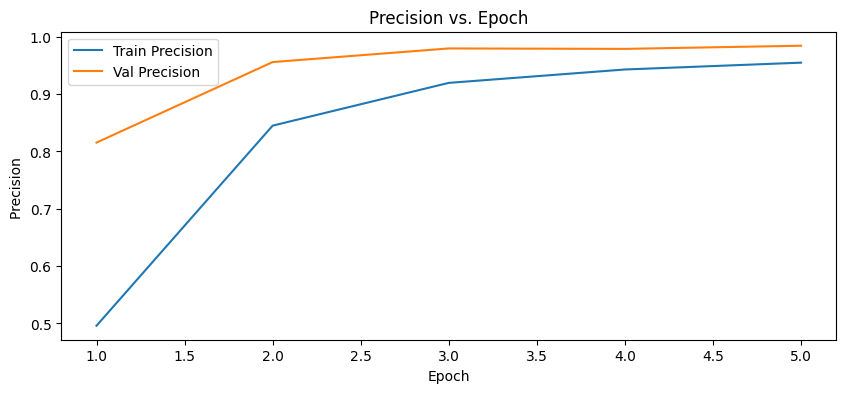

In [11]:
import numpy as np
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()

# Plot F1 Scores Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_f1_scores, label="Train F1 Score")
plt.plot(range(1, num_epochs+1), val_f1_scores, label="Val F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Epoch")
plt.legend()
plt.show()


# Plot Precision Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_precisions, label="Train Precision")
plt.plot(range(1, num_epochs+1), val_precisions, label="Val Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision ")
plt.title("Precision vs. Epoch")
plt.legend()
plt.show()



# Plot Precision Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_precisions, label="Train Precision")
plt.plot(range(1, num_epochs+1), val_precisions, label="Val Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision ")
plt.title("Precision vs. Epoch")
plt.legend()
plt.show()


## Moment of Truth , Evaluate Model on Test Set

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Function to evaluate model

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return all_labels, all_preds

# Evaluate on Test Set
all_labels, all_preds = evaluate_model(model, test_loader, device)


Accuracy: 0.9898
Precision: 0.9899
Recall: 0.9897
F1-score: 0.9898


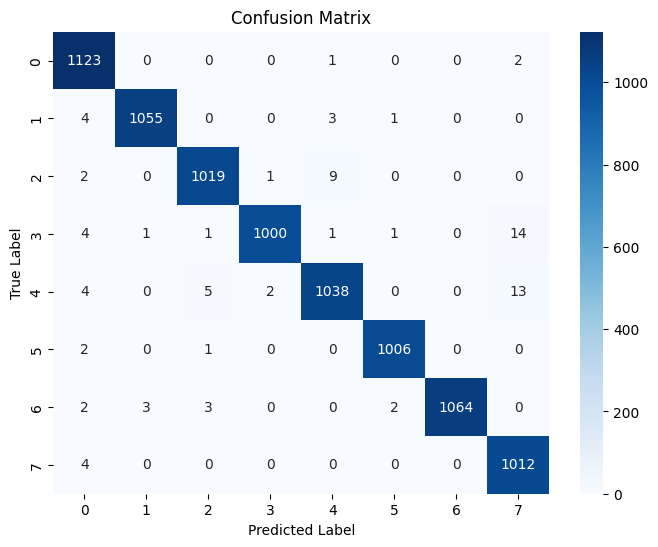

In [14]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(8), yticklabels=range(8))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#### Here I have got 98 pecent accuracy on test set containing 8416 examples using only simple ANN without changing any hyperparameters and  training 4 epochs only. This proves one thing that is , CNNs are just memory optimization of neural networks. If you have large available memory then just simply create a large neural network and it will learn better than CNN.